# Description
This project looks to create a CNN on hand gesture image dataset using a Functional API with preprocessing from MobileNet. A sequential model was also built for testing to compare results.

- Results from training yielded great results from both MobileNet and sequential model, with a accuracy and validation accuracy of over 99%.




# Table of Contents
- [Import Libraries](#Import-Libraries)
- [Organize the Data](#Organize-the-data)
    - [Create labels](#Create-labels)
    - [Create Train/Validation/Test folders](#Create-Train/Validation/Test-folders)
- [Preprocess data using Mobilenet](#Preprocess-data-using-Mobilenet)
    - [Verify batches](#Verify-batches)
    - [View training batch images](#[View-training-batch-images])
- [Modify MobileNet Model](#Modify-MobileNet-Model)
    - [Specify layers to be used in Model](#[Specify-layers-to-be-used-in-Model])
    - [Create model from Mobilenet using modification](#Create-model-from-Mobilenet-using-modification)
    - [Freeze Layers](#Freeze-Layers)
- [Build Sequential Model (Optional)](#Build-Sequential-Model-(Optional))
- [Train Model](#Train-Model)
- [Save the Model](#Save-the-Model)
- [Load the Model](#Load-the-Model)
- [Test Performance](#Test-Performance)
    - [View test batches images](#View-test-batches-images)
    - [Predict](#Predict)
        - [Predict on Live Images(Webcam)](#Predict-on-Live-Images(Webcam))
        - [Predict on Random Images](#Predict-on-Random-Images)
        - [Predict on test batch](#Predict-on-test-batch)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Plot validation history](#Plot-validation-history)
    - [Plot accuracy history](#Plot-accuracy-history])
    - [Metrics](#Metrics)

# **Import Libraries**

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.utils import to_categorical
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

#Webcam recognition
import cv2
from ipywidgets import Image, HBox, VBox
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import display
import ipywidgets as widgets
#from google.colab.output import eval_js
from base64 import b64decode
import PIL
import io
from concurrent.futures import ThreadPoolExecutor


2024-09-25 18:09:54.207192: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Organize the data

## Create labels

In [2]:
path = '/Volumes/Datasets/Hagrid/hagrid-classification-512p'

In [ ]:
# Create classes (directories) if they don't exist
for dir_name in ['mute', 'ok', 'like', 'dislike', 'stop']:
    target_dir_path = os.path.join(path, dir_name)
    if not os.path.exists(target_dir_path):
        os.makedirs(target_dir_path)


keywords_to_dirs ={
    'mute': 'mute',
    'ok': 'ok',
    'like': 'like',
    'dislike': 'dislike',
    'stop': 'stop'
}


# Iterate through the directories and subdirectories
for root, dirs, files in os.walk(os.path.join(path, 'raw train data')):
    for dir_name in dirs:
        for keyword, target_dir in keywords_to_dirs.items():
            if keyword in dir_name:
                source_dir = os.path.join(root, dir_name)

                # Full path to the target directory where files should be copied
                full_target_dir = os.path.join(path, target_dir)

                # Copy each file in the source directory to the target directory
                for file_name in os.listdir(source_dir):
                    file_path = os.path.join(source_dir, file_name)
                    if os.path.isfile(file_path):  # Ensure it's a file
                        shutil.copy(file_path, full_target_dir)
                        print(f"Copied {file_name} to {full_target_dir}")

print("Files copied successfully.")

## Create Train/Validation/Test folders

In [22]:
os.chdir(path)

# Function to copy a single file (used in parallel execution)
def copy_file(src, dst):
    if os.path.isfile(src):
        shutil.copy2(src, dst)
    else:
        print(f"Source file does not exist: {src}")

def move_file(src, dst):
    try:
        if os.path.isfile(src):
            shutil.move(src, dst)
        else:
            print(f"Source file does not exist: {src}")
    except Exception as e:
        print(f"Error moving {src} to {dst}: {e}")

if os.path.isdir('train/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    folder_name = ['mute', 'ok', 'like', 'dislike', 'stop']
    for name in folder_name:
        # Create the target subdirectory in the 'train' folder
        target_train_dir = os.path.join('train', name)
        os.mkdir(target_train_dir)

        # Copy the contents of the source folder to the target subdirectory
        # shutil.copytree(name, target_train_dir, dirs_exist_ok=True)
        
        # Set the source directory path
        source_dir = os.path.join(path, name)
        origin_samples = random.sample(os.listdir(source_dir), 7000)
        
        # List of source and destination file paths
        file_pairs = [
            (os.path.join(source_dir, t), os.path.join(target_train_dir, t))
            for t in origin_samples
        ]

        # Copy files in parallel using ThreadPoolExecutor
        with ThreadPoolExecutor() as executor:
            executor.map(lambda args: copy_file(*args), file_pairs)
            
        # Create the corresponding validation and test directories
        valid_dir = os.path.join('valid', name)
        test_dir = os.path.join('test', name)
        
        os.mkdir(valid_dir)
        os.mkdir(test_dir)

        # Select and move files from 'train' to 'valid' folder
        valid_samples = random.sample(os.listdir(target_train_dir), 1000)
        valid_file_pairs = [
            (os.path.join(target_train_dir, j), os.path.join(valid_dir, j))
            for j in valid_samples
        ]
        with ThreadPoolExecutor() as executor:
            executor.map(lambda args: move_file(*args), valid_file_pairs)

        # Select and move files from 'train' to 'test' folder
        test_samples = random.sample(os.listdir(target_train_dir), 500)
        test_file_pairs = [
            (os.path.join(target_train_dir, k), os.path.join(test_dir, k))
            for k in test_samples
        ]
        with ThreadPoolExecutor() as executor:
            executor.map(lambda args: move_file(*args), test_file_pairs)

    os.chdir('../..')

# **Preprocess data using Mobilenet**


In [8]:
# Paths to train/valid/test directories
path = '/Volumes/Datasets/Hagrid/hagrid-classification-512p/'
train_path =  path+'train'
valid_path = path+'valid'
test_path = path+'test'

In [9]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory = train_path, target_size=(224,224), batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory = valid_path, target_size=(224,224), batch_size = 10)
    #Set shuffle equal to false
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)\
    .flow_from_directory(directory = test_path, target_size=(224,224), batch_size = 10,\
                        shuffle=False)

Found 27500 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.


## Verify batches

In [10]:
assert train_batches.n == 27500
assert valid_batches.n == 5000
assert test_batches.n == 2500
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 5

## View training batch images

In [11]:
# Get the mapping from class index to class label (name)
def PlotImages(batches):
  images, label = next(batches)
  class_labels = {v: k for k, v in batches.class_indices.items()}

  fig, ax = plt.subplots(ncols=6, figsize=(20,20))

  for i in range(0,6):
      ax[i].imshow(images[i])
      ax[i].title.set_text(f'{class_labels[label[i].argmax()]}')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


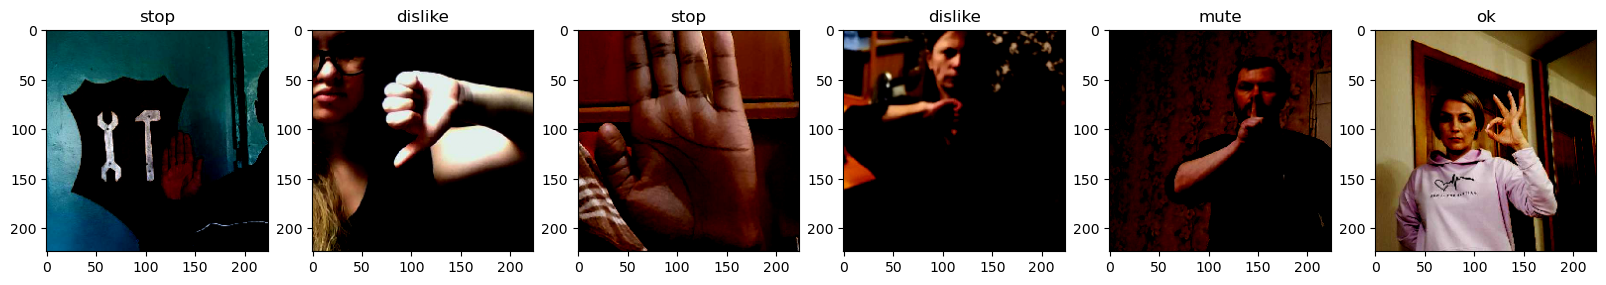

In [12]:
PlotImages(train_batches)

# Modify MobileNet Model

In [30]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [31]:
mobile.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

## Specify layers to be used in Model

In [32]:
x = mobile.layers[-1].output
output = Dense(units=5, activation= 'softmax')(x)

## Create model from Mobilenet using modification

In [33]:
model = Model(inputs= mobile.input, outputs=output)

## Freeze Layers

In [34]:
#Freezes top 23 layers
for layer in model.layers[:-23]:
    layer.trainable = False

In [35]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,258,869 (16.25 MB)

 Trainable params: 2,887,029 (11.01 MB)

 Non-trainable params: 1,371,840 (5.23 MB)

# Build Sequential Model (Optional)

In [ ]:
model = Sequential()

In [ ]:
model.add(Conv2D(16, 3, padding='same',  activation = 'relu', input_shape = (224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding='same' , activation = 'relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding='same',  activation = 'relu'))
model.add(MaxPool2D())

#Condense the layer down to a single dimension
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,870,181 (49.10 MB)

 Trainable params: 12,870,181 (49.10 MB)

 Non-trainable params: 0 (0.00 B)

# **Train Model**

In [36]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
es = EarlyStopping(monitor= 'val_accuracy', patience = 5)

In [ ]:
#Note: Took 5hrs to run

In [39]:
hist = model.fit(x=train_batches, validation_data=valid_batches, epochs=30, callbacks = [es])

Epoch 1/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 33284s 12s/step - accuracy: 0.8691 - loss: 1.4609 - val_accuracy: 0.9828 - val_loss: 1.1918
Epoch 2/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 3331s 1s/step - accuracy: 0.9755 - loss: 1.1234 - val_accuracy: 0.9824 - val_loss: 0.9163
Epoch 3/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 2844s 1s/step - accuracy: 0.9827 - loss: 0.8568 - val_accuracy: 0.9886 - val_loss: 0.6852
Epoch 4/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 975s 354ms/step - accuracy: 0.9876 - loss: 0.6374 - val_accuracy: 0.9908 - val_loss: 0.5009
Epoch 5/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 962s 349ms/step - accuracy: 0.9926 - loss: 0.4616 - val_accuracy: 0.9898 - val_loss: 0.3677
Epoch 6/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 984s 357ms/step - accuracy: 0.9941 - loss: 0.3315 - val_accuracy: 0.9892 - val_loss: 0.2693
Epoch 7/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1015s 369ms/step - accuracy: 0.9953 - loss: 0.2359 - val_accuracy: 0.9894 - val_loss: 0.1977
Epoch 8/30
2750/2750 ━━━━━━━━━━━━━━━━━━━━ 1077s 391ms/step - accu

# **Save the Model**

In [14]:
code_path = '/Volumes/Datasets/HandGesture/models'

In [41]:
model.save(os.path.join(code_path,'HagridModel2.keras'))

# **Load the Model**

In [15]:
model = load_model(os.path.join(code_path,'HagridModel1.keras'))

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 10,032,929 (38.27 MB)

 Trainable params: 2,887,029 (11.01 MB)

 Non-trainable params: 1,371,840 (5.23 MB)

 Optimizer params: 5,774,060 (22.03 MB)

# **Test Performance**

## View test batches images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


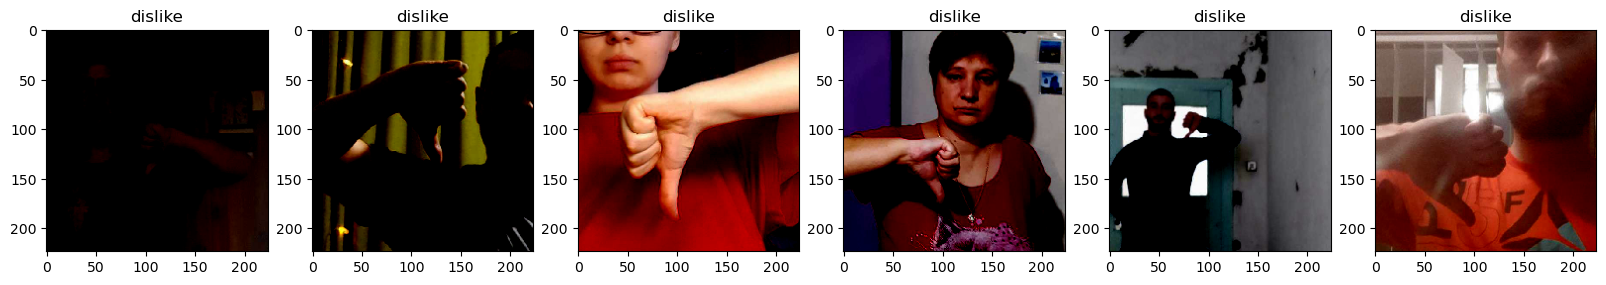

In [42]:
PlotImages(test_batches)

## Predict


### Predict on Live Images(Webcam)

In [43]:
#Note: For Google Colab environment only
# Function to convert base64 image to cv2 image
def base64_to_cv2(base64_string):
    imgdata = b64decode(base64_string)
    img = PIL.Image.open(io.BytesIO(imgdata))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)


# JavaScript to capture image from webcam
js = '''
async function takePhoto(quality) {
    const div = document.createElement('div');
    const capture = document.createElement('button');
    capture.textContent = 'Capture';
    div.appendChild(capture);

    const video = document.createElement('video');
    video.style.display = 'block';
    const stream = await navigator.mediaDevices.getUserMedia({video: true});
    div.appendChild(video);
    video.srcObject = stream;
    await video.play();

    document.body.appendChild(div);

    return new Promise((resolve) => {
        capture.onclick = () => {
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            resolve(canvas.toDataURL('image/jpeg', quality));
        };
    });
}
'''

# Define labels
labels = ['dislike', 'like', 'mute', 'ok', 'stop']

# Create output widget
output_widget = widgets.Output()

# Function to process frame and make prediction
def process_frame(frame):
    # Resize the frame to match your model's input size
    img_resized = cv2.resize(frame, (224, 224))

    # Convert to float32
    img_float32 = np.float32(img_resized)

    # Preprocess the image using MobileNet's preprocessing function
    img_preprocessed = preprocess_input(img_float32)

    # Add a batch dimension
    img_batch = np.expand_dims(img_preprocessed, axis=0)

    # Make prediction
    prediction = model.predict(img_batch)

    # Get the predicted class
    predicted_class = labels[prediction.argmax()]

    return prediction, predicted_class

# Function to capture and process image
def capture_and_process(b):
    # Capture image
    data = eval_js('takePhoto({})'.format(0.8))
    img = base64_to_cv2(data.split(',')[1])

    # Process image and get prediction
    confidence, prediction = process_frame(img)

    # Display result
    with output_widget:
        output_widget.clear_output()
        print(f"Prediction: {prediction}")
        print('Confidence level: ', confidence)
        display(PIL.Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

# Create capture button
button = widgets.Button(description="Capture and Predict")
button.on_click(capture_and_process)

# Display button and output
display(button, output_widget)

# Run JavaScript code
eval_js(js)

Button(description='Capture and Predict', style=ButtonStyle())

Output()

NameError: name 'eval_js' is not defined

In [ ]:
# Initialize webcam
cap = cv2.VideoCapture(0)

# Define labels
labels = ['dislike', 'like', 'mute', 'ok', 'stop']

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    # Convert BGR to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Resize the frame to match your model's input size
    img_resized = cv2.resize(frame_rgb, (224, 224))
    
    # Convert to float32
    img_float32 = np.float32(img_resized)
    
    # Preprocess the image using MobileNet's preprocessing function
    img_preprocessed = preprocess_input(img_float32)
    
    # Add a batch dimension
    img_batch = np.expand_dims(img_preprocessed, axis=0)

    # Make prediction
    prediction = model.predict(img_batch)
    
    # Get the predicted class
    predicted_class = labels[prediction.argmax()]

    # Draw the prediction on the frame
    cv2.putText(frame, f"Prediction: {predicted_class}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Display the resulting frame
    cv2.imshow('Hand Signature Detection', frame)

    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

2024-09-25 18:15:50.450 python[81195:6968521] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


### Predict on Random Images

In [23]:
def TestRandomImage(url):
  # Download the image
  image_path = tf.keras.utils.get_file(origin=url)
  # Read the image file
  img = tf.io.read_file(image_path)

  # Decode the image into a tensor
  img = tf.io.decode_image(img, channels=3)
  img_resized = tf.image.resize(img, [224, 224])
  # Preprocess the image using MobileNet's preprocessing function
  img_preprocessed = tf.keras.applications.mobilenet.preprocess_input(img_resized)
  # Add a batch dimension
  img_batch = tf.expand_dims(img_preprocessed, axis=0)
  plt.imshow(img_preprocessed)
  plt.axis('off')  # Hide axes
  plt.show()
  Prediction = model.predict(img_batch)
  labels = ['dislike', 'like', 'mute', 'ok', 'stop']
  print('Image prediction is: ', labels[Prediction.argmax()])
  print('Confidence level: ', Prediction)


In [28]:
#stop image
url = 'https://www.ncfp.org/wp-content/uploads/2016/09/Fist-to-Five-1024x535.png'

#thumbs down image
#url = 'https://t3.ftcdn.net/jpg/01/08/50/84/360_F_108508466_NCQw2TQBdQ1BD8wemIkVuWzDX4IWSgQg.jpg'

426151/426151 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


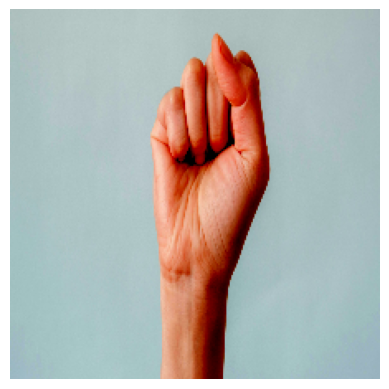

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image prediction is:  stop
Confidence level:  [[0.00450283 0.00568433 0.00529234 0.00829764 0.9762229 ]]


In [29]:
TestRandomImage(url)

### Predict on test batch

In [16]:
#Note: test labels werent shuffled in preprocessing, so they should be organized. Confirm
test_labels = test_batches.classes
test_labels

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

In [17]:
predictions = model.predict(x=test_batches, verbose=0)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [18]:
#Results of prediction
predictions.argmax(axis=1)

array([0, 0, 0, ..., 4, 4, 4])

## Confusion Matrix

In [19]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    '''This function prints and plots the confursion matrix.
    Normalization can be applied by setting "normalize=True".'''

    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j], horizontalalignment ='center', color='white' if cm[i,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
test_batches.class_indices

{'dislike': 0, 'like': 1, 'mute': 2, 'ok': 3, 'stop': 4}

In [21]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization
[[498   1   1   0   0]
 [  1 489   5   2   3]
 [  0   1 499   0   0]
 [  1   1   1 490   7]
 [  0   0   2   1 497]]


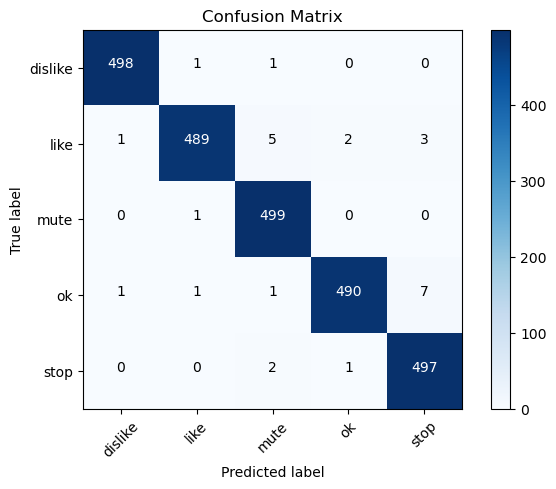

In [22]:
cm_plot_labels = ['dislike', 'like', 'mute', 'ok', 'stop']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Plot validation history

In [20]:
fig = plt.figure()
plt.plot(hist.history['loss'],  color = 'teal', label='loss')
plt.plot(hist.history['val_loss'],  color = 'orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

## Plot accuracy history


In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],  color = 'teal', label='accuracy')
plt.plot(hist.history['val_accuracy'],  color = 'orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Metrics


In [21]:
def Metrics(test_labels, predictions):
  #Accuracy Score
  accuracy = accuracy_score(test_labels, predictions.argmax(axis=1))
  #F1 Score
  f1 = f1_score(test_labels, predictions.argmax(axis=1), average='macro')
  #Top k accuracy score
  test_labels_one_hot = to_categorical(test_labels, num_classes=5)

  top_3_accuracy = top_k_categorical_accuracy(test_labels_one_hot, predictions, k=3)
  # Evaluate the accuracy as a percentage
  top_3_accuracy_result = np.mean(top_3_accuracy)

  print(f"Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nTop-3 Accuracy: {top_3_accuracy_result:.2f}")

In [22]:
Metrics(test_labels, predictions)

Accuracy: 0.99
F1 Score: 0.99
Top-3 Accuracy: 1.00
